Contains all tests for Project 3, FYS-STK4155

In [ ]:
from imports import *
from functions import analytical_diffusion, forward_Euler, g_trial, g_analytic, u, f
from classes import PINN
import imports
import functions
import importlib
import classes

importlib.reload(imports)
importlib.reload(functions)
importlib.reload(classes)

<module 'classes' from 'c:\\Users\\Jogga\\Documents\\H25\\FYS-STK4155\\Project-3\\Code\\classes.py'>

Testing the analyical solution

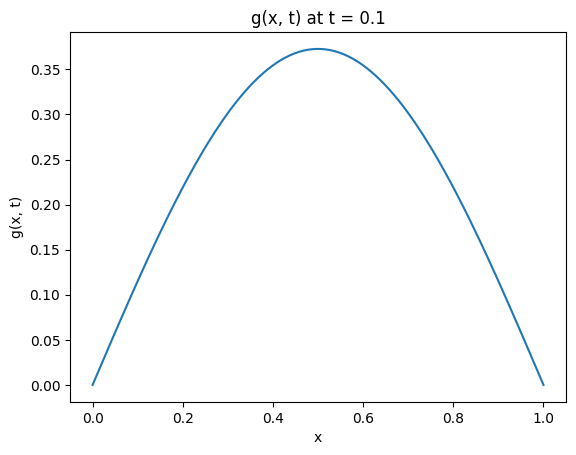

In [63]:
x = np.linspace(0, 1, 200)
t = 0.1
y = analytical_diffusion(x, t)

plt.figure()
plt.plot(x, y)
plt.xlabel("x")
plt.ylabel("g(x, t)")
plt.title(f"g(x, t) at t = {t}")
plt.show()

Testing the Forward Euler against analytical solution

c:\Users\Jogga\Documents\H25\FYS-STK4155\Project-3\Code\functions.py:46: RuntimeWarning: overflow encountered in divide
  
c:\Users\Jogga\Documents\H25\FYS-STK4155\Project-3\Code\functions.py:51: RuntimeWarning: invalid value encountered in add
  u_new = u.copy()


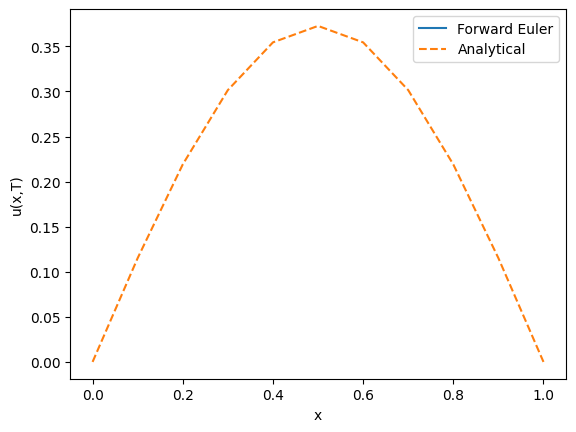

MSE: nan


In [11]:
T  = 0.1
Nt = 200
Nx = 50

x, t, U = forward_Euler(T, Nt, Nx)

u_FE = U[-1, :]
u_exact = np.exp(-np.pi**2 * T) * np.sin(np.pi * x)

plt.plot(x, u_FE, label="Forward Euler")
plt.plot(x, u_exact, "--", label="Analytical")
plt.xlabel("x")
plt.ylabel("u(x,T)")
plt.legend()
plt.show()
from sklearn.metrics import mean_squared_error
mse = np.mean((u_FE- u_exact)**2)

print(f"MSE: {mse:.6e}")

**(b)**: testing for different displacement steps $\Delta x$, and studying solutions

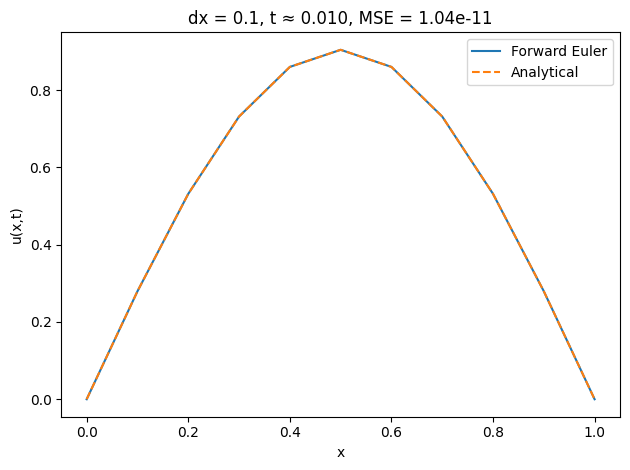

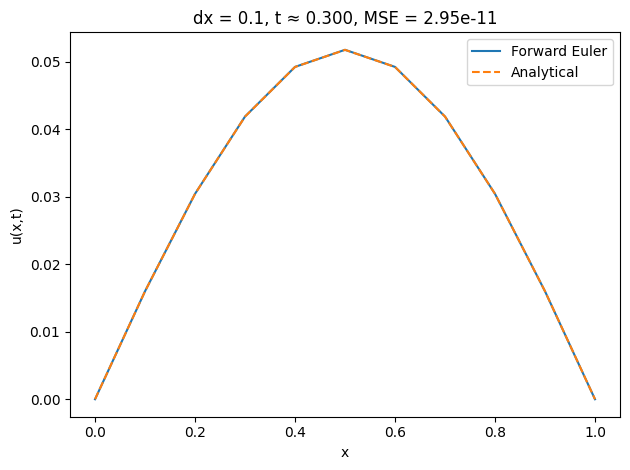

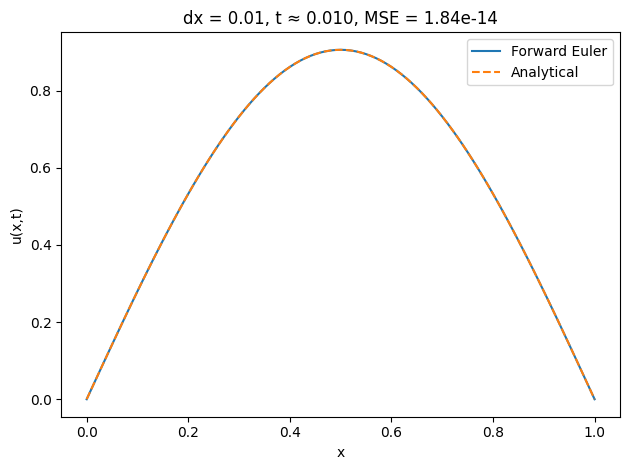

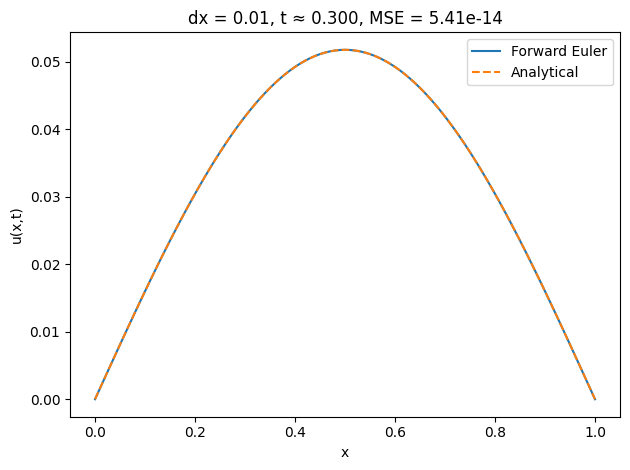

In [77]:
dx_values = [0.1, 0.01]
t1 = 0.01
t2 = 0.3
T_final = t2
alpha = 0.5

for dx in dx_values:
    x, t, U = forward_Euler(dx, T_final, alpha=alpha)

    idx1 = np.argmin(np.abs(t - t1))
    u_num_t1 = U[idx1, :]
    u_ex_t1 = analytical_diffusion(x, t[idx1])
    mse_t1 = np.mean((u_num_t1 - u_ex_t1)**2)

    plt.figure()
    plt.plot(x, u_num_t1, label="Forward Euler")
    plt.plot(x, u_ex_t1, "--", label="Analytical")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title(f"dx = {dx}, t ≈ {t[idx1]:.3f}, MSE = {mse_t1:.2e}")
    plt.legend()
    plt.tight_layout()
    plt.show()

    idx2 = np.argmin(np.abs(t - t2))
    u_num_t2 = U[idx2, :]
    u_ex_t2 = analytical_diffusion(x, t[idx2])
    mse_t2 = np.mean((u_num_t2 - u_ex_t2)**2)

    plt.figure()
    plt.plot(x, u_num_t2, label="Forward Euler")
    plt.plot(x, u_ex_t2, "--", label="Analytical")
    plt.xlabel("x")
    plt.ylabel("u(x,t)")
    plt.title(f"dx = {dx}, t ≈ {t[idx2]:.3f}, MSE = {mse_t2:.2e}")
    plt.legend()
    plt.tight_layout()
    plt.show()




Initial cost:  41.05505310046362
Final cost:  3.5239387203396433
Max absolute difference between the analytical solution and the network: 0.362021


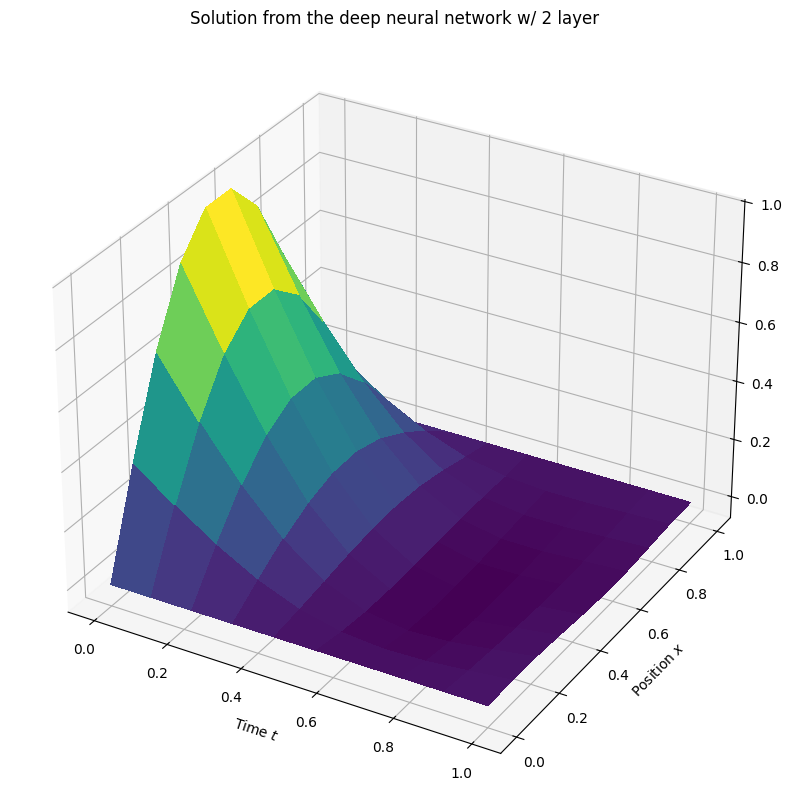

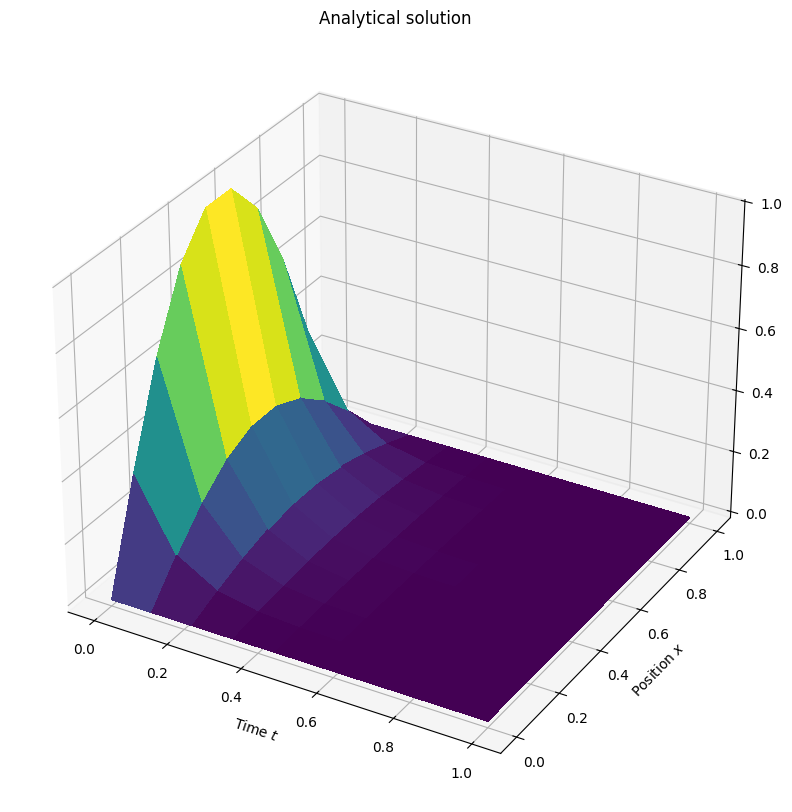

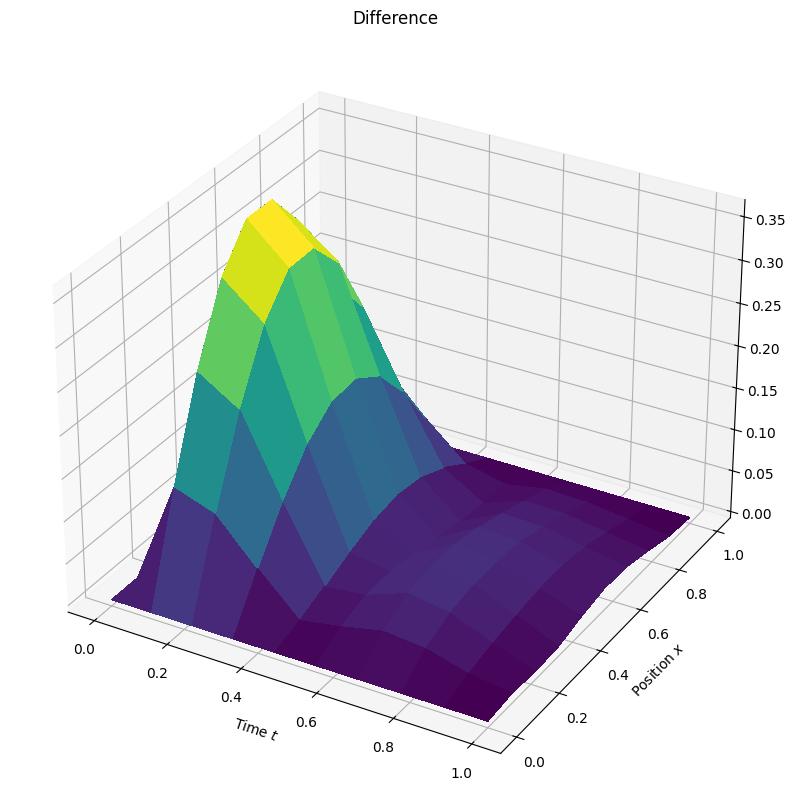

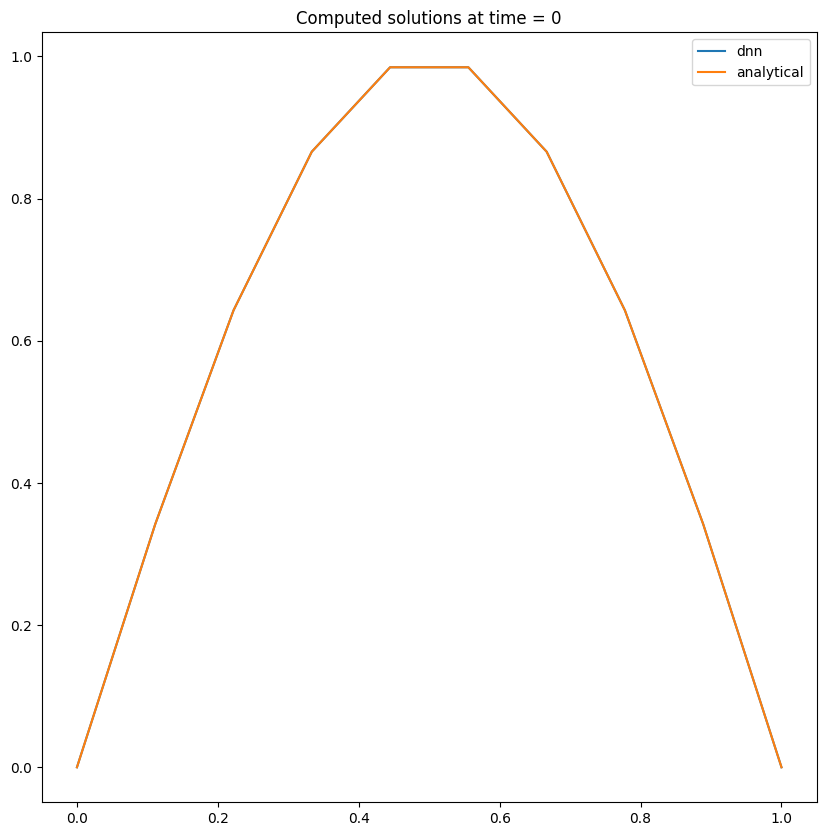

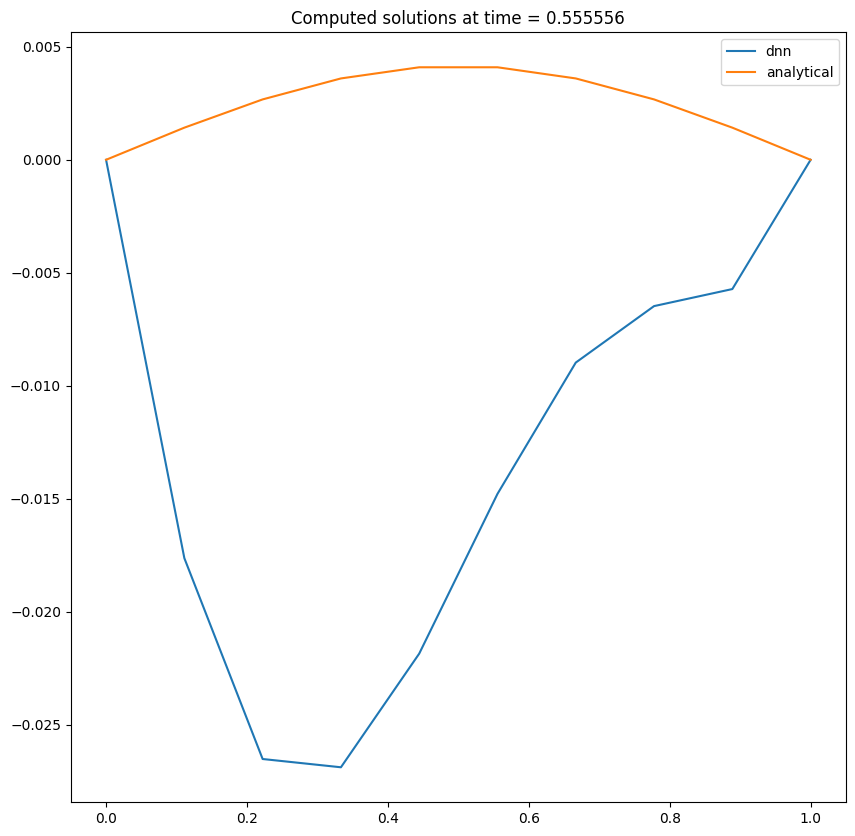

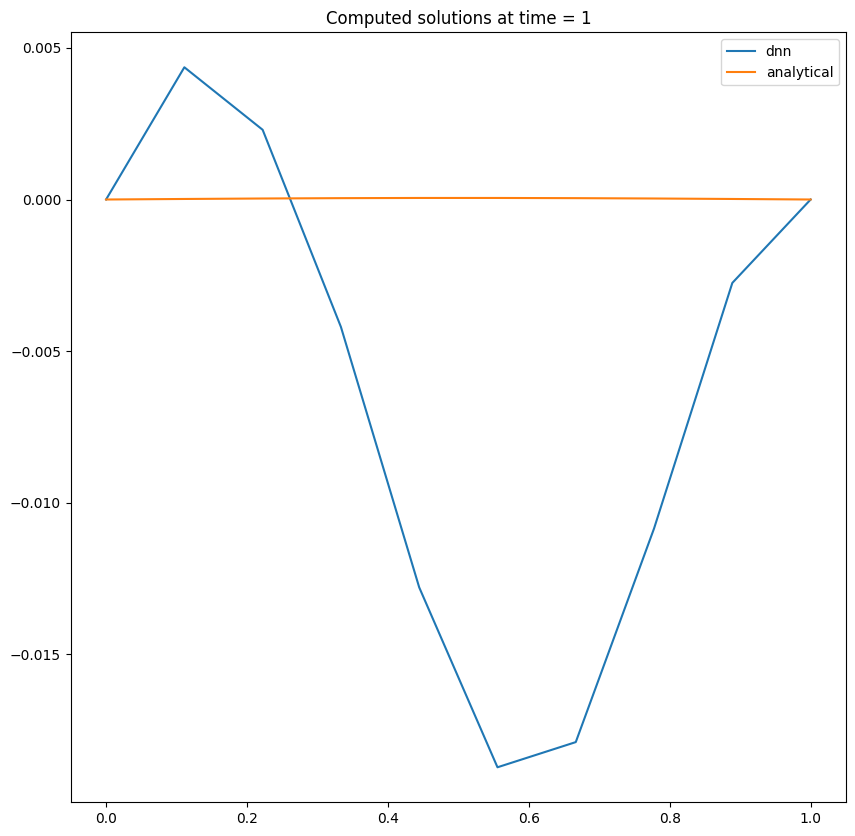

In [ ]:
import autograd.numpy as np
from autograd import jacobian,hessian,grad
import autograd.numpy.random as npr
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d

## Set up the network

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def deep_neural_network(deep_params, x):
    # x is now a point and a 1D numpy array; make it a column vector
    num_coordinates = np.size(x,0)
    x = x.reshape(num_coordinates,-1)

    num_points = np.size(x,1)

    # N_hidden is the number of hidden layers
    N_hidden = len(deep_params) - 1 # -1 since params consist of parameters to all the hidden layers AND the output layer

    # Assume that the input layer does nothing to the input x
    x_input = x
    x_prev = x_input

    ## Hidden layers:

    for l in range(N_hidden):
        # From the list of parameters P; find the correct weigths and bias for this layer
        w_hidden = deep_params[l]

        # Add a row of ones to include bias
        x_prev = np.concatenate((np.ones((1,num_points)), x_prev ), axis = 0)

        z_hidden = np.matmul(w_hidden, x_prev)
        x_hidden = sigmoid(z_hidden)

        # Update x_prev such that next layer can use the output from this layer
        x_prev = x_hidden

    ## Output layer:

    # Get the weights and bias for this layer
    w_output = deep_params[-1]

    # Include bias:
    x_prev = np.concatenate((np.ones((1,num_points)), x_prev), axis = 0)

    z_output = np.matmul(w_output, x_prev)
    x_output = z_output

    return x_output[0][0]

## Define the trial solution and cost function
def u(x):
    return np.sin(np.pi*x)

def g_trial(point,P):
    x,t = point
    return (1-t)*u(x) + x*(1-x)*t*deep_neural_network(P,point)

# The right side of the ODE:
def f(point):
    return 0.

# The cost function:
def cost_function(P, x, t):
    cost_sum = 0

    g_t_jacobian_func = jacobian(g_trial)
    g_t_hessian_func = hessian(g_trial)

    for x_ in x:
        for t_ in t:
            point = np.array([x_,t_])

            g_t = g_trial(point,P)
            g_t_jacobian = g_t_jacobian_func(point,P)
            g_t_hessian = g_t_hessian_func(point,P)

            g_t_dt = g_t_jacobian[1]
            g_t_d2x = g_t_hessian[0][0]

            func = f(point)

            err_sqr = ( (g_t_dt - g_t_d2x) - func)**2
            cost_sum += err_sqr

    return cost_sum /( np.size(x)*np.size(t) )

## For comparison, define the analytical solution
def g_analytic(point):
    x,t = point
    return np.exp(-np.pi**2*t)*np.sin(np.pi*x)

## Set up a function for training the network to solve for the equation
def solve_pde_deep_neural_network(x,t, num_neurons, num_iter, lmb):
    ## Set up initial weigths and biases
    N_hidden = np.size(num_neurons)

    P = [None]*(N_hidden + 1) 

    P[0] = npr.randn(num_neurons[0], 2 + 1 ) 
    for l in range(1,N_hidden):
        P[l] = npr.randn(num_neurons[l], num_neurons[l-1] + 1) 

    P[-1] = npr.randn(1, num_neurons[-1] + 1 ) 

    print('Initial cost: ',cost_function(P, x, t))

    cost_function_grad = grad(cost_function,0)

    # Let the update be done num_iter times
    for i in range(num_iter):
        cost_grad =  cost_function_grad(P, x , t)

        for l in range(N_hidden+1):
            P[l] = P[l] - lmb * cost_grad[l]

    print('Final cost: ',cost_function(P, x, t))

    return P

if __name__ == '__main__':
    ### Use the neural network:
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    Nx = 10; Nt = 10
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0,1,Nt)

    ## Set up the parameters for the network
    num_hidden_neurons = [100, 25]
    num_iter = 250
    lmb = 0.01

    P = solve_pde_deep_neural_network(x,t, num_hidden_neurons, num_iter, lmb)

    ## Store the results
    g_dnn_ag = np.zeros((Nx, Nt))
    G_analytical = np.zeros((Nx, Nt))
    for i,x_ in enumerate(x):
        for j, t_ in enumerate(t):
            point = np.array([x_, t_])
            g_dnn_ag[i,j] = g_trial(point,P)

            G_analytical[i,j] = g_analytic(point)

    # Find the map difference between the analytical and the computed solution
    diff_ag = np.abs(g_dnn_ag - G_analytical)
    print('Max absolute difference between the analytical solution and the network: %g'%np.max(diff_ag))

    ## Plot the solutions in two dimensions, that being in position and time

    T,X = np.meshgrid(t,x)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Solution from the deep neural network w/ %d layer'%len(num_hidden_neurons))
    s = ax.plot_surface(T,X,g_dnn_ag,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Analytical solution')
    s = ax.plot_surface(T,X,G_analytical,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(projection='3d')
    ax.set_title('Difference')
    s = ax.plot_surface(T,X,diff_ag,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');

    ## Take some slices of the 3D plots just to see the solutions at particular times
    indx1 = 0
    indx2 = int(Nt/2)
    indx3 = Nt-1

    t1 = t[indx1]
    t2 = t[indx2]
    t3 = t[indx3]

    # Slice the results from the DNN
    res1 = g_dnn_ag[:,indx1]
    res2 = g_dnn_ag[:,indx2]
    res3 = g_dnn_ag[:,indx3]

    # Slice the analytical results
    res_analytical1 = G_analytical[:,indx1]
    res_analytical2 = G_analytical[:,indx2]
    res_analytical3 = G_analytical[:,indx3]

    # Plot the slices
    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t1)
    plt.plot(x, res1)
    plt.plot(x,res_analytical1)
    plt.legend(['dnn','analytical'])

    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t2)
    plt.plot(x, res2)
    plt.plot(x,res_analytical2)
    plt.legend(['dnn','analytical'])

    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t3)
    plt.plot(x, res3)
    plt.plot(x,res_analytical3)
    plt.legend(['dnn','analytical'])

    plt.show()

Homemade PINN

In [ ]:
if __name__ == '__main__':
    ### Use the neural network:
    npr.seed(15)

    ## Decide the vales of arguments to the function to solve
    Nx = 10; Nt = 10
    x = np.linspace(0, 1, Nx)
    t = np.linspace(0,1,Nt)

    ## Set up the parameters for the network
    num_hidden_neurons = [100, 25]
    num_iter = 250
    lmb = 0.01

    P = solve_pde_deep_neural_network(x,t, num_hidden_neurons, num_iter, lmb)

    ## Store the results
    g_dnn_ag = np.zeros((Nx, Nt))
    G_analytical = np.zeros((Nx, Nt))
    for i,x_ in enumerate(x):
        for j, t_ in enumerate(t):
            point = np.array([x_, t_])
            g_dnn_ag[i,j] = g_trial(point,P)

            G_analytical[i,j] = g_analytic(point)

    # Find the map difference between the analytical and the computed solution
    diff_ag = np.abs(g_dnn_ag - G_analytical)
    print('Max absolute difference between the analytical solution and the network: %g'%np.max(diff_ag))

    ## Plot the solutions in two dimensions, that being in position and time

    T,X = np.meshgrid(t,x)

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_suplot(projection='3d')
    ax.set_title('Solution from the deep neural network w/ %d layer'%len(num_hidden_neurons))
    s = ax.plot_surface(T,X,g_dnn_ag,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');


    fig = plt.figure(figsize=(10,10))
    ax = fig.add_suplot(projection='3d')
    ax.set_title('Analytical solution')
    s = ax.plot_surface(T,X,G_analytical,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_suplot(projection='3d')
    ax.set_title('Difference')
    s = ax.plot_surface(T,X,diff_ag,linewidth=0,antialiased=False,cmap=cm.viridis)
    ax.set_xlabel('Time $t$')
    ax.set_ylabel('Position $x$');

    ## Take some slices of the 3D plots just to see the solutions at particular times
    indx1 = 0
    indx2 = int(Nt/2)
    indx3 = Nt-1

    t1 = t[indx1]
    t2 = t[indx2]
    t3 = t[indx3]

    # Slice the results from the DNN
    res1 = g_dnn_ag[:,indx1]
    res2 = g_dnn_ag[:,indx2]
    res3 = g_dnn_ag[:,indx3]

    # Slice the analytical results
    res_analytical1 = G_analytical[:,indx1]
    res_analytical2 = G_analytical[:,indx2]
    res_analytical3 = G_analytical[:,indx3]

    # Plot the slices
    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t1)
    plt.plot(x, res1)
    plt.plot(x,res_analytical1)
    plt.legend(['dnn','analytical'])

    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t2)
    plt.plot(x, res2)
    plt.plot(x,res_analytical2)
    plt.legend(['dnn','analytical'])

    plt.figure(figsize=(10,10))
    plt.title("Computed solutions at time = %g"%t3)
    plt.plot(x, res3)
    plt.plot(x,res_analytical3)
    plt.legend(['dnn','analytical'])

    plt.show()


=== Experiment: 2×20 tanh ===
Layers: [2, 20, 20, 1], activation: tanh
Epoch     0 | Loss = 2.600e+01
Epoch   500 | Loss = 6.855e+00
Epoch  1000 | Loss = 6.506e+00
Epoch  1500 | Loss = 6.405e+00
MSE vs analytical at t=0.1: 3.757e-02


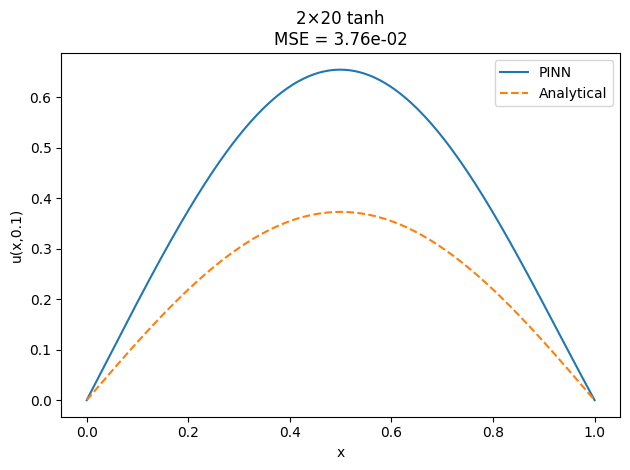


=== Experiment: 2×50 tanh ===
Layers: [2, 50, 50, 1], activation: tanh
Epoch     0 | Loss = 2.827e+01
Epoch   500 | Loss = 6.574e+00
Epoch  1000 | Loss = 3.922e+00
Epoch  1500 | Loss = 3.623e-01
MSE vs analytical at t=0.1: 4.125e-05


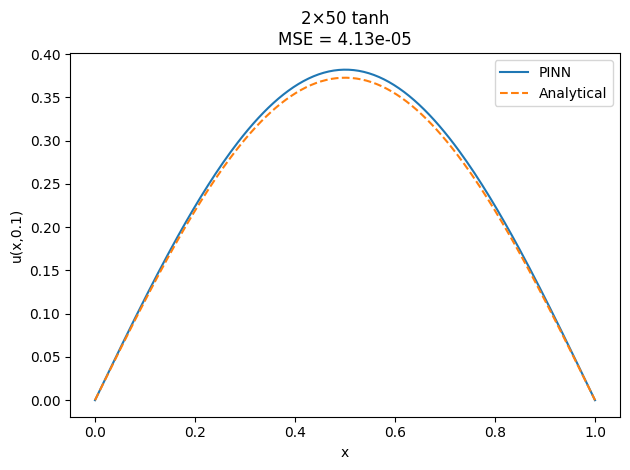


=== Experiment: 2×20 ReLU ===
Layers: [2, 20, 20, 1], activation: relu
Epoch     0 | Loss = 2.566e+01
Epoch   500 | Loss = 6.381e+00
Epoch  1000 | Loss = 1.452e+00
Epoch  1500 | Loss = 9.427e-01
MSE vs analytical at t=0.1: 9.835e-04


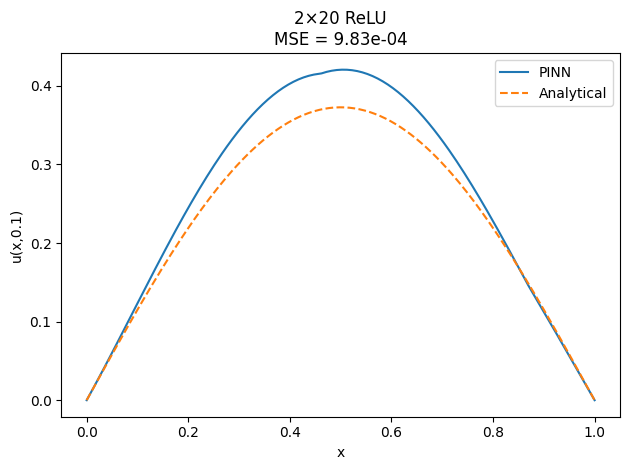


=== Experiment: 3×50 ReLU ===
Layers: [2, 50, 50, 50, 1], activation: relu
Epoch     0 | Loss = 2.687e+01
Epoch   500 | Loss = 2.695e-01
Epoch  1000 | Loss = 1.103e+00
Epoch  1500 | Loss = 6.700e-01
MSE vs analytical at t=0.1: 2.894e-04


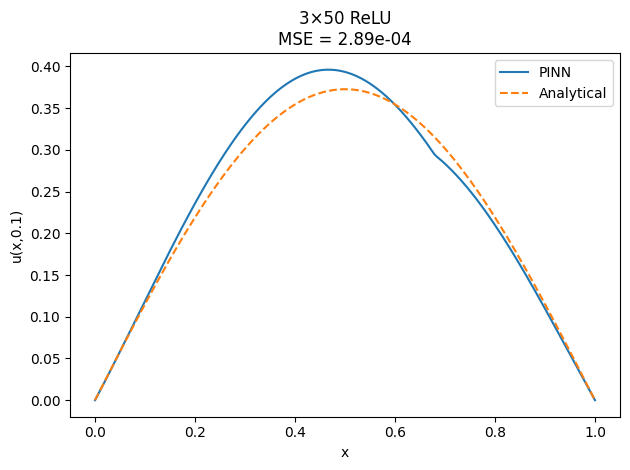


=== Experiment: 2×20 tanh ===
Layers: [2, 20, 20, 1], activation: sigmoid
Epoch     0 | Loss = 2.451e+01
Epoch   500 | Loss = 7.696e+00
Epoch  1000 | Loss = 7.560e+00
Epoch  1500 | Loss = 7.445e+00
MSE vs analytical at t=0.1: 4.271e-02


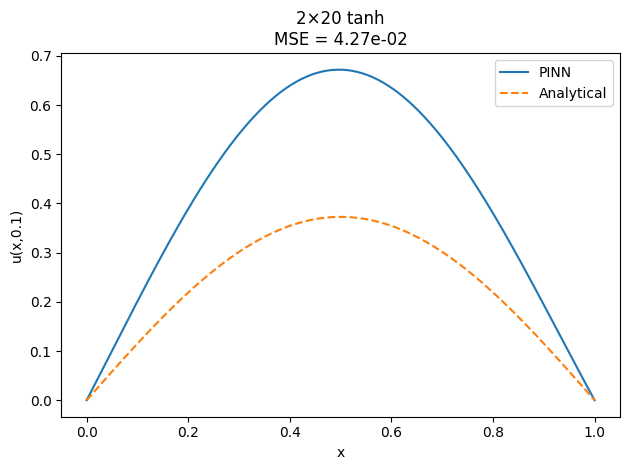


=== Experiment: 2×50 tanh ===
Layers: [2, 50, 50, 1], activation: sigmoid
Epoch     0 | Loss = 2.847e+01
Epoch   500 | Loss = 7.595e+00
Epoch  1000 | Loss = 7.546e+00
Epoch  1500 | Loss = 7.002e+00
MSE vs analytical at t=0.1: 3.832e-02


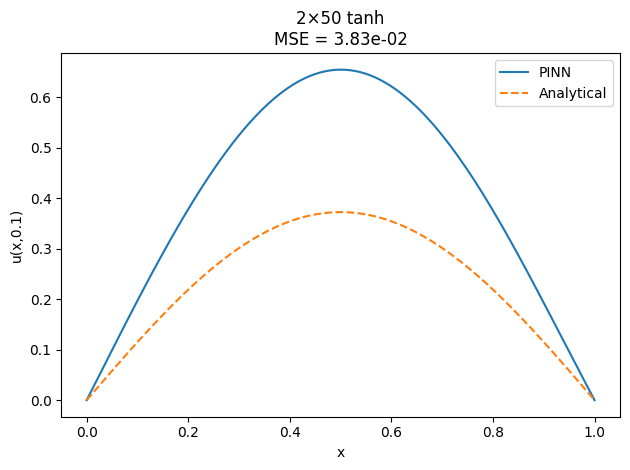


=== Experiment: 2×20 GeLU ===
Layers: [2, 20, 20, 1], activation: gelu
Epoch     0 | Loss = 2.692e+01
Epoch   500 | Loss = 5.528e+00
Epoch  1000 | Loss = 8.695e-01
Epoch  1500 | Loss = 2.449e-01
MSE vs analytical at t=0.1: 3.195e-06


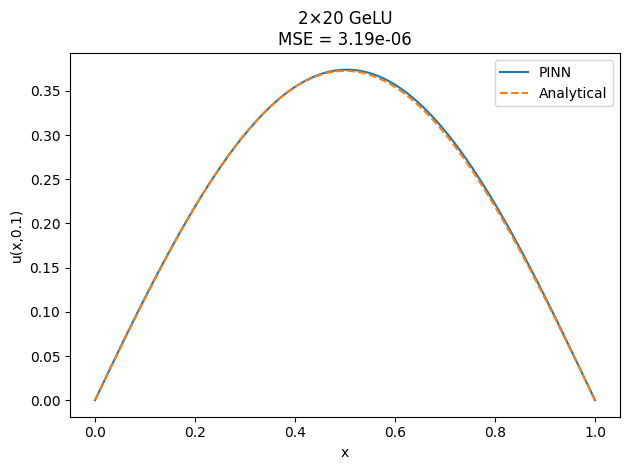


=== Experiment: 3×50 GeLU ===
Layers: [2, 50, 50, 50, 1], activation: gelu
Epoch     0 | Loss = 2.637e+01
Epoch   500 | Loss = 5.641e-01
Epoch  1000 | Loss = 1.944e-02
Epoch  1500 | Loss = 6.860e-03
MSE vs analytical at t=0.1: 1.853e-06


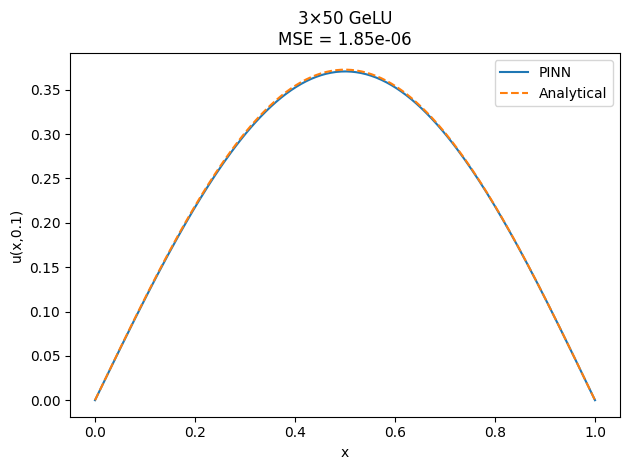

In [ ]:
def make_collocation(Nx=50, Nt=50, T=0.3):
    x = torch.linspace(0.0, 1.0, Nx)
    t = torch.linspace(0.0, T, Nt)
    X, Tm = torch.meshgrid(x, t, indexing="ij")
    x_coll = X.reshape(-1, 1)
    t_coll = Tm.reshape(-1, 1)
    return x_coll, t_coll



def analytical_u(x, t_scalar):
    x_np = x.detach().cpu().numpy().flatten()
    return np.exp(-np.pi**2 * t_scalar) * np.sin(np.pi * x_np)



def run_experiment(layers, activation, label,
                   Nx=50, Nt=50, T=0.3,
                   epochs=3000, lr=1e-3,
                   t_eval=0.1):
    print(f"\n=== Experiment: {label} ===")
    print(f"Layers: {layers}, activation: {activation}")

    x_coll, t_coll = make_collocation(Nx=Nx, Nt=Nt, T=T)
    model = PINN(layers=layers, activation=activation)

    model.train_pinn(x_coll, t_coll, epochs=epochs, lr=lr, verbose_every=500)

    with torch.no_grad():
        x_test = torch.linspace(0, 1, 200).reshape(-1, 1)
        t_test = torch.full_like(x_test, t_eval)
        u_pinn = model.trial_solution(x_test, t_test).cpu().numpy().flatten()

    u_exact = analytical_u(x_test, t_eval)
    mse = np.mean((u_pinn - u_exact)**2)
    print(f"MSE vs analytical at t={t_eval}: {mse:.3e}")

    plt.figure()
    plt.plot(x_test.cpu().numpy(), u_pinn, label="PINN")
    plt.plot(x_test.cpu().numpy(), u_exact, "--", label="Analytical")
    plt.xlabel("x")
    plt.ylabel(f"u(x,{t_eval})")
    plt.title(f"{label}\nMSE = {mse:.2e}")
    plt.legend()
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    configs = [
        {"layers": [2, 20, 20, 1], "activation": "tanh",   "label": "2×20 tanh"},
        {"layers": [2, 50, 50, 1], "activation": "tanh",   "label": "2×50 tanh"},
        {"layers": [2, 20, 20, 1], "activation": "relu",   "label": "2×20 ReLU"},
        {"layers": [2, 50, 50, 50, 1], "activation": "relu", "label": "3×50 ReLU"},
        {"layers": [2, 20, 20, 1], "activation": "sigmoid",   "label": "2×20 tanh"},
        {"layers": [2, 50, 50, 1], "activation": "sigmoid",   "label": "2×50 tanh"},
        {"layers": [2, 20, 20, 1], "activation": "gelu",   "label": "2×20 GeLU"},
        {"layers": [2, 50, 50, 50, 1], "activation": "gelu", "label": "3×50 GeLU"},
    ]

    for cfg in configs:
        run_experiment(
            layers=cfg["layers"],
            activation=cfg["activation"],
            label=cfg["label"],
            Nx=40,
            Nt=40,
            T=0.3,
            epochs=2000,   # bump up/down as needed
            lr=1e-3,
            t_eval=0.1
        )



=== Experiment: 2×20 tanh ===
Layers: [2, 20, 20, 1], activation: tanh
Epoch     0 | Loss = 2.802e+01
Epoch   500 | Loss = 6.602e+00
Epoch  1000 | Loss = 6.301e+00
Epoch  1500 | Loss = 5.650e-01
MSE vs analytical at t=0.1: 3.836e-05


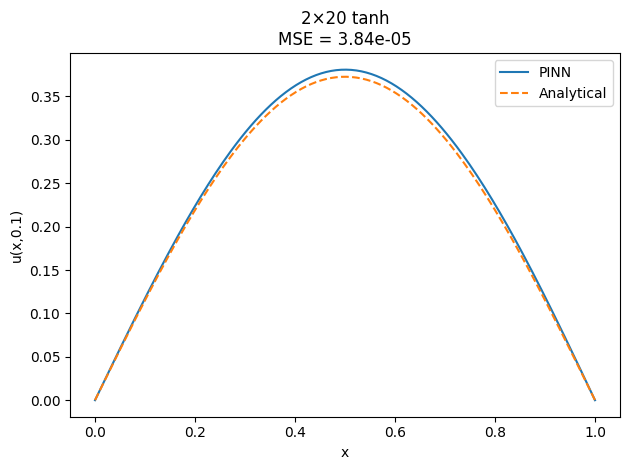


=== Experiment: 2×50 tanh ===
Layers: [2, 50, 50, 1], activation: tanh
Epoch     0 | Loss = 2.801e+01
Epoch   500 | Loss = 1.281e+00
Epoch  1000 | Loss = 7.936e-02
Epoch  1500 | Loss = 2.155e-02
MSE vs analytical at t=0.1: 6.013e-06


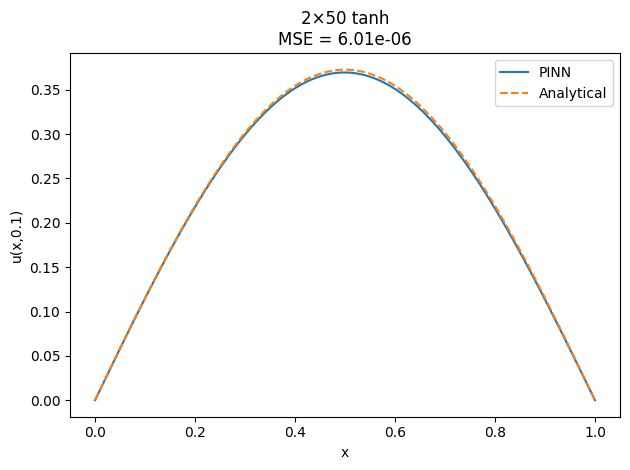


=== Experiment: 2×20 ReLU ===
Layers: [2, 20, 20, 1], activation: relu
Epoch     0 | Loss = 2.699e+01
Epoch   500 | Loss = 4.920e+00
Epoch  1000 | Loss = 1.370e+00
Epoch  1500 | Loss = 1.168e+00
MSE vs analytical at t=0.1: 2.241e-04


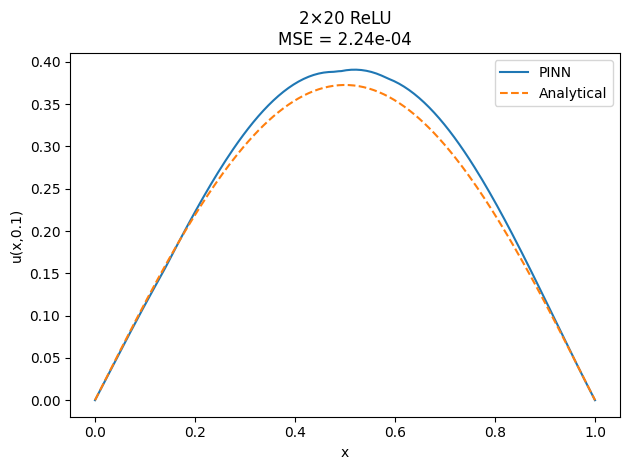


=== Experiment: 3×50 ReLU ===
Layers: [2, 50, 50, 50, 1], activation: relu
Epoch     0 | Loss = 2.735e+01
Epoch   500 | Loss = 5.159e-01
Epoch  1000 | Loss = 5.126e-01
Epoch  1500 | Loss = 6.422e-01
MSE vs analytical at t=0.1: 1.546e-04


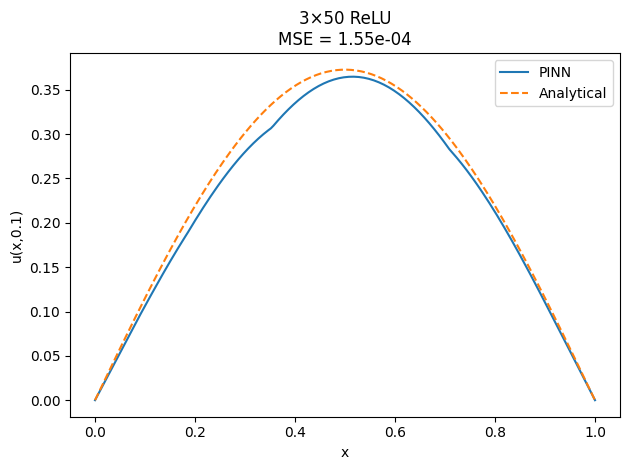


=== Experiment: 2×20 sigmoid ===
Layers: [2, 20, 20, 1], activation: sigmoid
Epoch     0 | Loss = 2.608e+01
Epoch   500 | Loss = 7.597e+00
Epoch  1000 | Loss = 7.331e+00
Epoch  1500 | Loss = 6.350e+00
MSE vs analytical at t=0.1: 3.762e-02


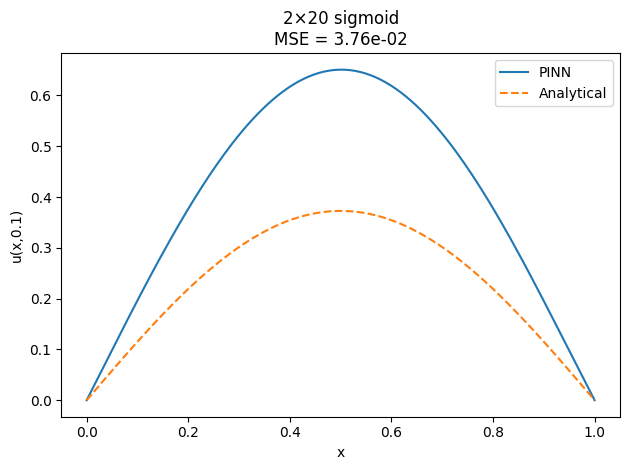


=== Experiment: 2×50 sigmoid ===
Layers: [2, 50, 50, 1], activation: sigmoid
Epoch     0 | Loss = 2.648e+01
Epoch   500 | Loss = 7.563e+00
Epoch  1000 | Loss = 3.195e+00
Epoch  1500 | Loss = 3.941e-01
MSE vs analytical at t=0.1: 3.071e-05


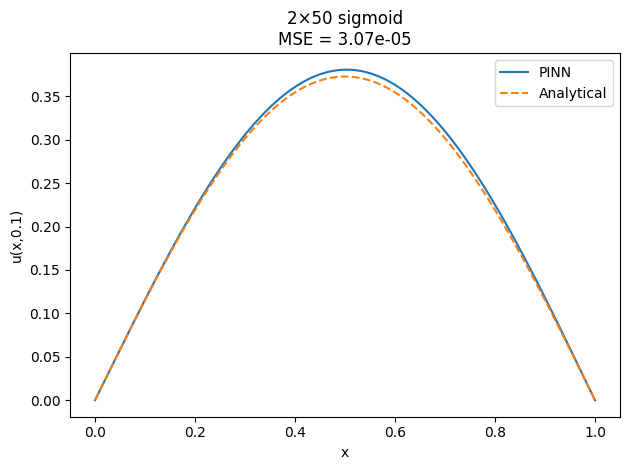


=== Experiment: 2×20 GeLU ===
Layers: [2, 20, 20, 1], activation: gelu
Epoch     0 | Loss = 2.655e+01
Epoch   500 | Loss = 2.992e+00
Epoch  1000 | Loss = 5.827e-01
Epoch  1500 | Loss = 2.442e-01
MSE vs analytical at t=0.1: 1.090e-06


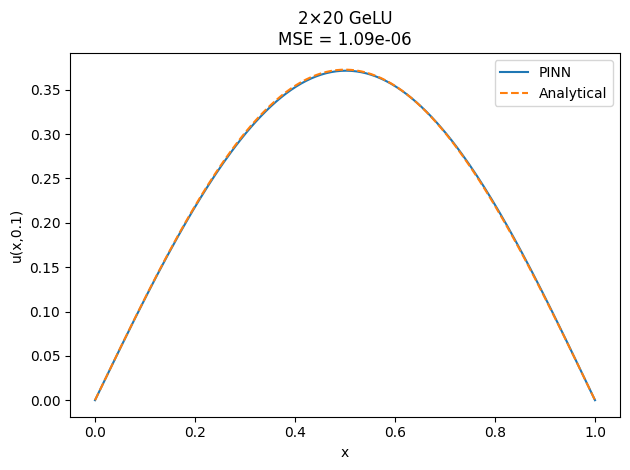


=== Experiment: 3×50 GeLU ===
Layers: [2, 50, 50, 50, 1], activation: gelu
Epoch     0 | Loss = 2.777e+01
Epoch   500 | Loss = 1.247e-01
Epoch  1000 | Loss = 4.839e-02
Epoch  1500 | Loss = 3.783e-02
MSE vs analytical at t=0.1: 1.779e-04


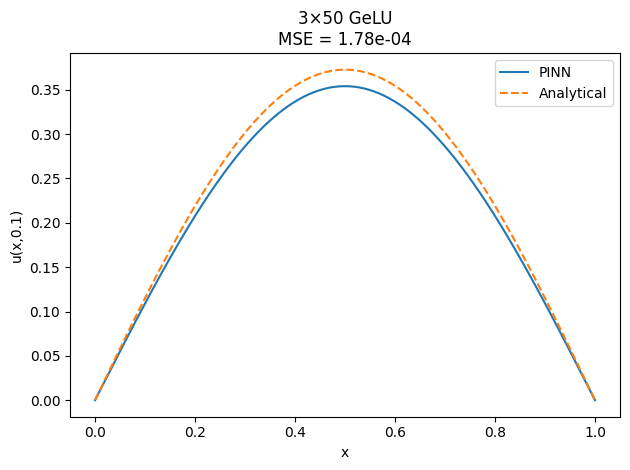

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt


def get_activation(name):
    if isinstance(name, nn.Module):
        return name
    name = name.lower()
    if name == "tanh":
        return nn.Tanh()
    if name == "relu":
        return nn.ReLU()
    if name == "sigmoid":
        return nn.Sigmoid()
    if name == "gelu":
        return nn.GELU()
    raise ValueError(f"Unknown activation: {name}")


class PINN(nn.Module):
    """
    PINN for u_t = u_xx on x in [0,1], t in [0,T],
    with u(x,0) = sin(pi x), u(0,t) = u(1,t) = 0.

    Trial solution:
        g(x,t) = (1 - t) sin(pi x) + x (1 - x) t N_theta(x,t)
    """

    def __init__(self, layers, activation="tanh", device=None):
        super().__init__()

        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = torch.device(device)

        act = get_activation(activation)

        modules = []
        for in_dim, out_dim in zip(layers[:-2], layers[1:-1]):
            modules.append(nn.Linear(in_dim, out_dim))
            modules.append(act)
        modules.append(nn.Linear(layers[-2], layers[-1]))
        self.net = nn.Sequential(*modules)

        self.to(self.device)

    def network(self, x, t):
        inp = torch.cat([x, t], dim=1)  # (N,2)
        return self.net(inp)            # (N,1)

    def u0(self, x):
        return torch.sin(torch.pi * x)

    def trial_solution(self, x, t):
        N = self.network(x, t)
        return (1.0 - t) * self.u0(x) + x * (1.0 - x) * t * N

    def f(self, x, t):
        return torch.zeros_like(x)

    def residual(self, x, t):
        x = x.clone().detach().to(self.device).requires_grad_(True)
        t = t.clone().detach().to(self.device).requires_grad_(True)

        g = self.trial_solution(x, t)

        g_t = torch.autograd.grad(
            g, t,
            grad_outputs=torch.ones_like(g),
            create_graph=True,
            retain_graph=True,
        )[0]

        g_x = torch.autograd.grad(
            g, x,
            grad_outputs=torch.ones_like(g),
            create_graph=True,
            retain_graph=True,
        )[0]

        g_xx = torch.autograd.grad(
            g_x, x,
            grad_outputs=torch.ones_like(g_x),
            create_graph=True,
            retain_graph=True,
        )[0]

        r = g_t - g_xx - self.f(x, t)
        return r

    def loss(self, x_coll, t_coll):
        r = self.residual(x_coll, t_coll)
        return torch.mean(r**2)

    def train_pinn(self, x_coll, t_coll,
                   epochs=5000, lr=1e-3,
                   optimizer_cls=optim.RMSprop,
                   verbose_every=500):
        x_coll = x_coll.reshape(-1, 1).to(self.device)
        t_coll = t_coll.reshape(-1, 1).to(self.device)

        optimizer = optimizer_cls(self.parameters(), lr=lr)

        for epoch in range(epochs):
            optimizer.zero_grad()
            loss = self.loss(x_coll, t_coll)
            loss.backward()
            optimizer.step()

            if verbose_every and epoch % verbose_every == 0:
                print(f"Epoch {epoch:5d} | Loss = {loss.item():.3e}")

        return self



def make_collocation(Nx=50, Nt=50, T=0.3):
    x = torch.linspace(0.0, 1.0, Nx)
    t = torch.linspace(0.0, T, Nt)
    X, Tm = torch.meshgrid(x, t, indexing="ij")
    x_coll = X.reshape(-1, 1)
    t_coll = Tm.reshape(-1, 1)
    return x_coll, t_coll



def analytical_u(x, t_scalar):
    x_np = x.detach().cpu().numpy().flatten()
    return np.exp(-np.pi**2 * t_scalar) * np.sin(np.pi * x_np)



def run_experiment(layers, activation, label,
                   Nx=50, Nt=50, T=0.3,
                   epochs=3000, lr=1e-3,
                   t_eval=0.1):
    print(f"\n=== Experiment: {label} ===")
    print(f"Layers: {layers}, activation: {activation}")

    x_coll, t_coll = make_collocation(Nx=Nx, Nt=Nt, T=T)
    model = PINN(layers=layers, activation=activation)

    model.train_pinn(x_coll, t_coll, epochs=epochs, lr=lr, verbose_every=500)

    with torch.no_grad():
        x_test = torch.linspace(0, 1, 200).reshape(-1, 1)
        t_test = torch.full_like(x_test, t_eval)
        u_pinn = model.trial_solution(x_test, t_test).cpu().numpy().flatten()

    u_exact = analytical_u(x_test, t_eval)
    mse = np.mean((u_pinn - u_exact)**2)
    print(f"MSE vs analytical at t={t_eval}: {mse:.3e}")

    plt.figure()
    plt.plot(x_test.cpu().numpy(), u_pinn, label="PINN")
    plt.plot(x_test.cpu().numpy(), u_exact, "--", label="Analytical")
    plt.xlabel("x")
    plt.ylabel(f"u(x,{t_eval})")
    plt.title(f"{label}\nMSE = {mse:.2e}")
    plt.legend()
    plt.tight_layout()
    plt.show()



if __name__ == "__main__":
    configs = [
        {"layers": [2, 20, 20, 1], "activation": "tanh",   "label": "2×20 tanh"},
        {"layers": [2, 50, 50, 1], "activation": "tanh",   "label": "2×50 tanh"},
        {"layers": [2, 20, 20, 1], "activation": "relu",   "label": "2×20 ReLU"},
        {"layers": [2, 50, 50, 50, 1], "activation": "relu", "label": "3×50 ReLU"},
        {"layers": [2, 20, 20, 1], "activation": "sigmoid",   "label": "2×20 sigmoid"},
        {"layers": [2, 50, 50, 1], "activation": "sigmoid",   "label": "2×50 sigmoid"},
        {"layers": [2, 20, 20, 1], "activation": "gelu",   "label": "2×20 GeLU"},
        {"layers": [2, 50, 50, 50, 1], "activation": "gelu", "label": "3×50 GeLU"},
    ]

    for cfg in configs:
        run_experiment(
            layers=cfg["layers"],
            activation=cfg["activation"],
            label=cfg["label"],
            Nx=40,
            Nt=40,
            T=0.3,
            epochs=2000,   # bump up/down as needed
            lr=1e-3,
            t_eval=0.1
        )
